In [30]:
import sys
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.transforms import v2
from omegaconf import DictConfig
import matplotlib.pyplot as plt
from Transforms import Transforms

In [31]:
from pathlib import Path
# include ../../3_Datapreparation
project_dir = Path(os.getcwd()).resolve().parent
sys.path.append(str(project_dir / '1_HaGRID'))
from dataset import ClassificationDataset, DetectionDataset, HagridDataset
import constants

In [32]:
config = {
    "dataset": {
        "targets": ["fist", "three3", "no_gesture"],
        "annotations_test": "./../Data/test",
        "annotations_train": "./../Data/train",
        "annotations_val": "./../Data/val",
        "dataset_test": "./../Data/data",
        "dataset_train": "./../Data/data",
        "dataset_val": "./../Data/data",
        "subset": None,
        "one_class": True,
    }
}

# Convert config to DictConfig
conf = DictConfig(config)

In [33]:
#dataset = HagridDataset(conf=conf, dataset_type="test", transform=None)
crop_transform = Transforms.CropToBBox()
datasetBBox = DetectionDataset(conf=conf, dataset_type="train", transform=crop_transform)
datasetTarget = ClassificationDataset(conf=conf, dataset_type="train", transform=None)

Prepare train dataset: 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]


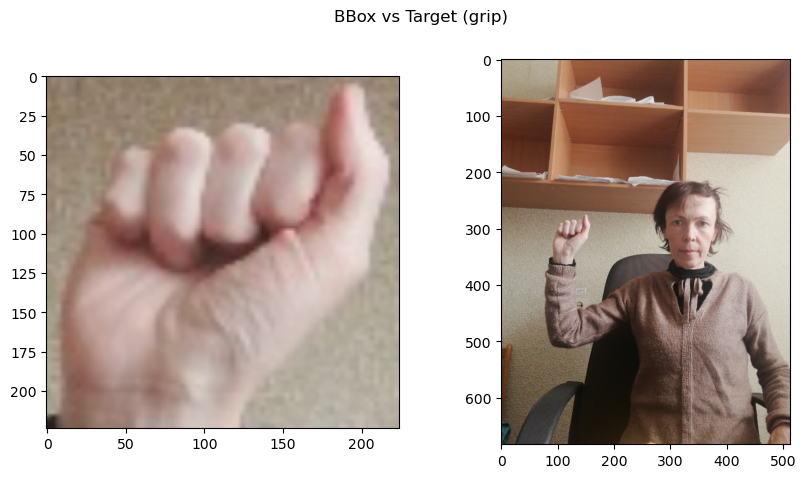

Image shape: torch.Size([3, 224, 224])


In [34]:
image_index = 7
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# print title wit the target
fig.suptitle(f"BBox vs Target ({constants.targets.get(datasetBBox[image_index][1]['labels'].item(), 'Unknown')})")
ax1.imshow(datasetBBox[image_index][0].permute(1, 2, 0))

ax2.imshow(datasetTarget[image_index][0])
plt.show()

# print the shape of the image
print(f"Image shape: {datasetBBox[image_index][0].shape}")


In [35]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from torchvision.models.resnet import ResNet18_Weights

In [36]:
# Load a pretrained ResNet model
resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Modify the fully connected layer to train for 3 classes
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 3)

# Print the modified model (optional)
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [40]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 5
batch_size = 32

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=learning_rate)

# Assuming you have your dataset ready
train_loader = DataLoader(dataset=DetectionDataset(conf=conf, dataset_type="train", transform=Transforms.CropToBBox()), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=DetectionDataset(conf=conf, dataset_type="test", transform=Transforms.CropToBBox()), batch_size=batch_size, shuffle=False)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)
print("Device:", device)

Prepare test dataset: 100%|██████████| 3/3 [00:00<00:00, 315.23it/s]

Device: cpu


In [41]:
#print the first element in the train_loader
for i, (images, labels) in enumerate(val_loader):
    print(images.shape)
    print(labels['labels'])
    break

torch.Size([32, 3, 224, 224])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.int32)


In [48]:
# Initialize lists to store losses
train_losses = []
val_losses = []

# Training and validation loop
for epoch in range(num_epochs):
    resnet.train()
    running_train_loss = 0.0
    
    # Training loop
    for inputs, labels in train_loader:
        inputs, labels = inputs.float().to(device), labels['labels'].long().to(device)

        optimizer.zero_grad()

        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    # Compute the average training loss for this epoch
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation loop (no gradients needed)
    resnet.eval()
    running_val_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.float().to(device), labels['labels'].long().to(device)

            outputs = resnet(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    # Compute the average validation loss for this epoch
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Print epoch summary
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

Epoch [1/5], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [2/5], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [3/5], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [4/5], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [5/5], Train Loss: 0.0000, Val Loss: 0.0000


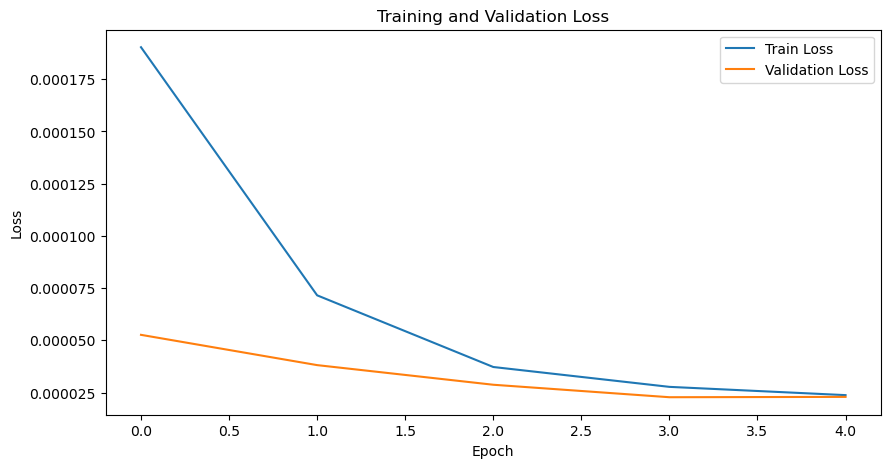

In [47]:
# Plot the training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()